In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import random

from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid


import PCA_functions as pf
import Extreme_functions as ef

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp

from Data import Data
from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import itertools
from collections import Counter
import pickle

from numpy import linalg as LA

import matplotlib.cm as cm

from scipy.special import inv_boxcox
from scipy import stats

from matplotlib import animation

import scipy.stats as st

import reverse_geocoder as rg

from pandas_datareader import wb
import scipy.stats as st

import Rung as rung

from pandas_datareader import wb

import seaborn as sns


import seaborn as sns
import feature_finder_keiko as ff
import feature_finder_f as ff1

from scipy import signal

plt.rcParams["figure.figsize"] = (20,10)

Could not import rpy package
Could not import r-package RCIT


/home/mathsys2/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def EOF_plot(pc, df_sst, Vr, lat_sst, lon_sst):

    df_sst["pc"] = Vr[:,pc-1]

    #lon1 = np.arange(-178.75,179.0,2.5)
    lon1_sst = np.arange(-180,180,2)
    #lat1 = np.arange(-40,40,2.5)

    deg = np.zeros((len(lat_sst),len(lon1_sst)))

    lat_number = deg.shape[0]
    lon_number = deg.shape[1]

    for i in range(lat_number):
        for j in range(lon_number):
            if not df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values.size == 0:
                deg[i,j] = df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values
            else:
                deg[i,j]=np.nan


    plt.figure(figsize=(30,15))
    #map = Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
    map = Basemap(projection='ortho',lat_0=45,lon_0=-100,resolution='l')
    #map.fillcontinents(color='grey', alpha=0.5)
    #map.drawcoastlines(linewidth=0.)


    xx, yy = meshgrid(lon1_sst, lat_sst)
    cs = map.pcolormesh(xx, yy, deg, cmap=plt.cm.Spectral_r)
    cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
    cbar.ax.tick_params(labelsize=35)
    #plt.savefig("EOF1.png")
    plt.show()

In [66]:
class_name = "BSh"

In [67]:
tau = 12

In [68]:
caus = np.load("../../whole_data_results/link_rotated_ET/best_link_all_1930_2000_{}_{}.npy".format(tau, class_name))

In [45]:
corr = np.load("../../whole_data_results/link_rotated_ET/best_link_corr_all_1930_2000_{}_{}.npy".format(tau, class_name))

array([[ 51, -14],
       [ 85, -13],
       [ 11, -20],
       [ 42, -21],
       [ 69, -14],
       [ 42, -22],
       [ 75, -14],
       [ 27, -22],
       [ 25, -24],
       [ 61, -18],
       [ 84, -13],
       [ 55, -13],
       [ 85, -16],
       [ 69, -12],
       [ 55, -14],
       [ 79, -16],
       [ 23, -16],
       [  8, -20],
       [ 70, -15]])

In [5]:
link_caus = np.load("../../whole_data_results/link_rotated_ET/best_link_all_1930_2000_{}.npy".format(tau))
link_corr = np.load("../../whole_data_results/link_rotated_ET/best_link_all_corr_1930_2000_{}.npy".format(tau))

In [69]:
caus

array([[  2, -17],
       [ 42, -22],
       [ 27, -23],
       [ 53, -21],
       [ 11, -22],
       [ 11, -12],
       [  7, -13],
       [ 82, -13],
       [ 66, -14],
       [ 25, -19],
       [  3, -13],
       [ 56, -19],
       [  9, -17],
       [ 82, -18],
       [ 42, -24],
       [ 36, -19],
       [ 38, -12],
       [ 82, -15]])

In [6]:
#np.load("../../whole_data_results/link_rotated_ET/best_link_all_corr_1930_2000_{}.npy".format(tau))

# Local California

In [4]:
train_start = 1976
validation_end = 2010

n_components_sst = 8

In [5]:
temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(validation_end, 12, 1, 0, 0)}
spatial_limits={"lon_min":180,"lon_max":240,"lat_min":40,"lat_max":26}

In [13]:
sst = Data('../../../nc/sst.mnmean.nc',"sst",temporal_limits,spatial_limits, missing_value= -9.96921e+36)

result = sst.get_data()
lon_sst_list = sst.get_lon_list()
lat_sst_list = sst.get_lat_list()
lon_sst = sst.get_lon()
lat_sst = sst.get_lat()

result_sst, avgs, stds = pf.deseasonalize_avg_std(np.array(result))
result_sst = signal.detrend(result_sst, axis=0)
weights = np.sqrt(np.abs(np.cos(np.array(lat_sst_list)* math.pi/180)))
for i in range(len(weights)):
    result_sst[:,i] = weights[i] * result_sst[:,i]

data_sst = pd.DataFrame(result_sst)

V, U, S, ts, eig, explained, max_comps = rung.pca_svd(data_sst,truncate_by='max_comps', max_comps=n_components_sst)


Vr, Rot = rung.varimax(V)
Vr = rung.svd_flip(Vr)

# Get explained variance of rotated components
s2 = np.diag(S)**2 / (ts.shape[0] - 1.)

# matrix with diagonal containing variances of rotated components
S2r = np.dot(np.dot(np.transpose(Rot), np.matrix(np.diag(s2))), Rot)
expvar = np.diag(S2r)

sorted_expvar = np.sort(expvar)[::-1]
# s_orig = ((Vt.shape[1] - 1) * s2) ** 0.5

# reorder all elements according to explained variance (descending)
nord = np.argsort(expvar)[::-1]
Vr = Vr[:, nord]

# Get time series of UNMASKED data
comps_ts = np.matmul(np.array(data_sst),Vr)

df_sst = pd.DataFrame({"lons":lon_sst_list,"lats":lat_sst_list})

lon_temp = df_sst["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_sst["lons"].vlues = lon_temp

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


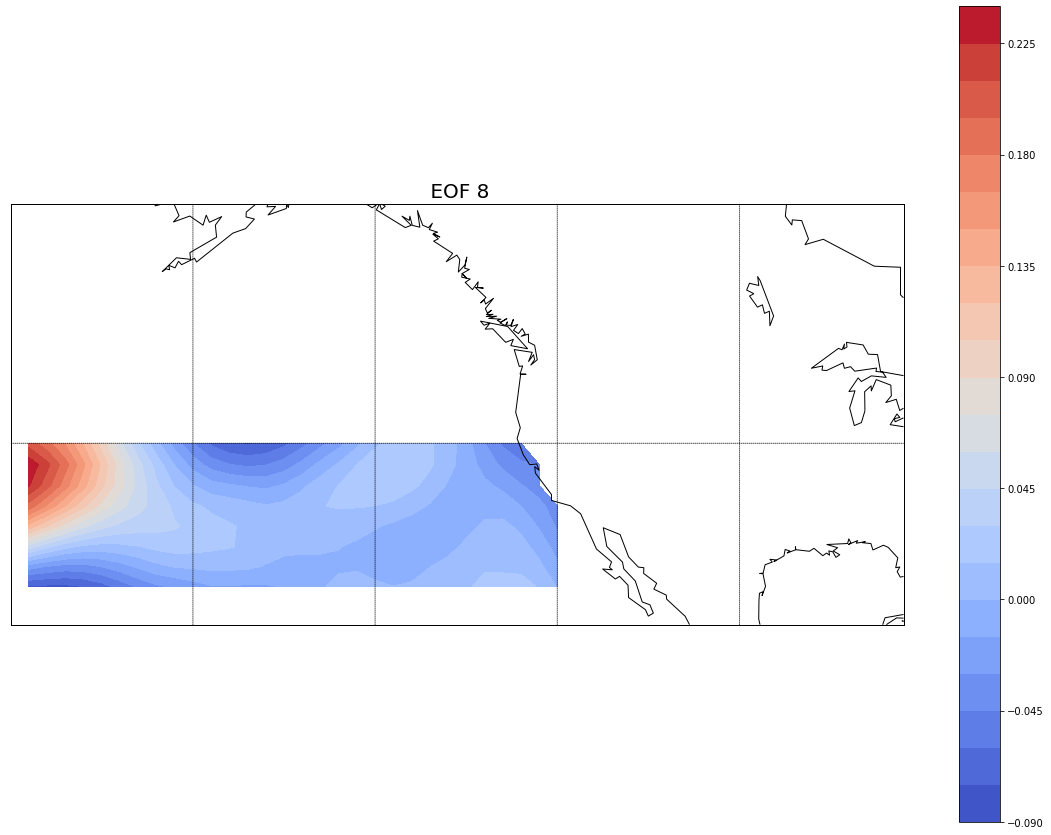

In [22]:
pc = 8

df_sst["pc"] = Vr[:,pc-1]

#lon1 = np.arange(-178.75,179.0,2.5)
lon1_sst = np.arange(-180,-80,2)
lat_sst = np.arange(60,0,-2)
#lat1 = np.arange(-40,40,2.5)

deg = np.zeros((len(lat_sst),len(lon1_sst)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values.size == 0:
            deg[i,j] = df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values
        else:
            deg[i,j]=np.nan


#plt.figure(figsize=(30,15))

lon  = lon1_sst
lat = lat_sst
#lat = np.arange(40,20,-2)
m=Basemap(projection='mill',lat_ts=10,llcrnrlon=lon1_sst.min(), \
  urcrnrlon=lon1_sst.max(),llcrnrlat=lat_sst.min()+20,urcrnrlat=lat_sst.max(), \
  resolution='c')

lon2, lat2 = np.meshgrid(lon,lat)
x, y = m(lon2, lat2)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='gray',lake_color='gray')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
m.drawmapboundary(fill_color='white')
cs = m.contourf(x,y,deg,20,cmap=plt.cm.get_cmap('coolwarm'))
plt.title(' EOF {}'.format(pc), fontsize = 20)
#cbar.ax.tick_params(labelsize=25)
plt.colorbar();
plt.savefig("./areas/Cal_Local_EOF{}.png".format(pc))

In [3]:
train_start = 1976
validation_end = 2010

n_components_sst = 57

In [4]:
temporal_limits = {"time_min":datetime(train_start, 1, 1, 0, 0),"time_max":datetime(validation_end, 12, 1, 0, 0)}
#original_count, count = ff.drought_timeseries("../ET_gamma_18912015.npy",train_start[ijz],validation_end[ijz])
data_sst, ts, V, df_sst, avg, std = ff.PCA_computer_rotated('../../../nc/sst.mnmean.nc', "sst",temporal_limits, n_components_sst, -9.96921e+36)

In [5]:
sst = Data('../../../nc/sst.mnmean.nc',"sst",temporal_limits, missing_value= -9.96921e+36)

result = sst.get_data()
lon_sst_list = sst.get_lon_list()
lat_sst_list = sst.get_lat_list()
lon_sst = sst.get_lon()
lat_sst = sst.get_lat()

In [11]:
result.shape

(420, 10988)

In [7]:
sst = Data('../../../nc/sst.mnmean.nc',"sst",temporal_limits, missing_value= -9.96921e+36)

result = sst.get_data()
lon_sst_list = sst.get_lon_list()
lat_sst_list = sst.get_lat_list()
lon_sst = sst.get_lon()
lat_sst = sst.get_lat()

result_sst, avgs, stds = pf.deseasonalize_avg_std(np.array(result))
result_sst = signal.detrend(result_sst, axis=0)
weights = np.sqrt(np.abs(np.cos(np.array(lat_sst_list)* math.pi/180)))
for i in range(len(weights)):
    result_sst[:,i] = weights[i] * result_sst[:,i]

data_sst = pd.DataFrame(result_sst)

V, U, S, ts, eig, explained, max_comps = rung.pca_svd(data_sst,truncate_by='max_comps', max_comps=n_components_sst)


Vr, Rot = rung.varimax(V)
Vr = rung.svd_flip(Vr)

# Get explained variance of rotated components
s2 = np.diag(S)**2 / (ts.shape[0] - 1.)

# matrix with diagonal containing variances of rotated components
S2r = np.dot(np.dot(np.transpose(Rot), np.matrix(np.diag(s2))), Rot)
expvar = np.diag(S2r)

sorted_expvar = np.sort(expvar)[::-1]
# s_orig = ((Vt.shape[1] - 1) * s2) ** 0.5

# reorder all elements according to explained variance (descending)
nord = np.argsort(expvar)[::-1]
Vr = Vr[:, nord]

# Get time series of UNMASKED data
comps_ts = np.matmul(np.array(data_sst),Vr)

df_sst = pd.DataFrame({"lons":lon_sst_list,"lats":lat_sst_list})

lon_temp = df_sst["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_sst["lons"].vlues = lon_temp

In [26]:
comps_ts_old = comps_ts

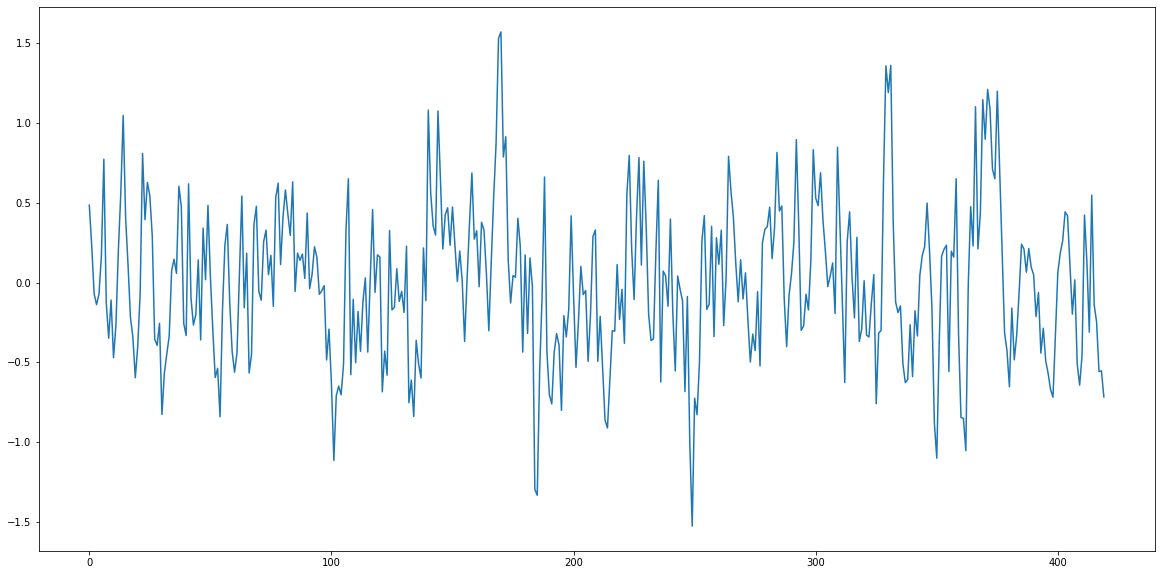

In [34]:
plt.plot(comps_ts[:,56])

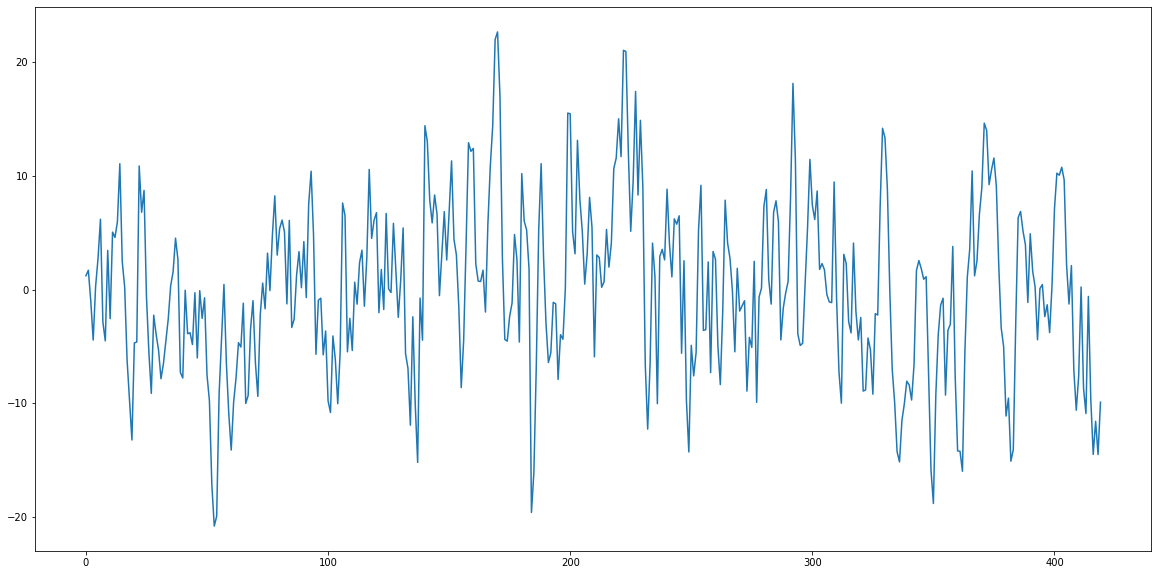

In [35]:
plt.plot(comps_ts_old[:,56])

In [17]:
def PCA_computer_rotated_mean(file_name, code, temporal_limits,n_components_sst=98, missing_value=-9.96921e+36):
    sst = Data(file_name,code,temporal_limits, missing_value= missing_value)

    result = sst.get_data()
    lon_sst_list = sst.get_lon_list()
    lat_sst_list = sst.get_lat_list()

    result_sst, avgs, stds = pf.deseasonalize_avg_std(np.array(result))
    result_sst = signal.detrend(result_sst, axis=0)
    weights = np.sqrt(np.abs(np.cos(np.array(lat_sst_list)* math.pi/180)))
    for i in range(len(weights)):
        result_sst[:,i] = weights[i] * result_sst[:,i]

    data_sst = pd.DataFrame(result_sst)
        
    V, U, S, ts, eig, explained, max_comps = rung.pca_svd(data_sst,truncate_by='max_comps', max_comps=n_components_sst)
    
    Vr, Rot = rung.varimax(V)
    Vr = rung.svd_flip(Vr)

    # Get explained variance of rotated components
    s2 = np.diag(S)**2 / (ts.shape[0] - 1.)

    # matrix with diagonal containing variances of rotated components
    S2r = np.dot(np.dot(np.transpose(Rot), np.matrix(np.diag(s2))), Rot)
    expvar = np.diag(S2r)

    sorted_expvar = np.sort(expvar)[::-1]
    # s_orig = ((Vt.shape[1] - 1) * s2) ** 0.5

    # reorder all elements according to explained variance (descending)
    nord = np.argsort(expvar)[::-1]
    Vr = Vr[:, nord]

    df_sst = pd.DataFrame({"lons":lon_sst_list,"lats":lat_sst_list})

    lon_temp = df_sst["lons"].values
    lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
    df_sst["lons"].vlues = lon_temp
    
    # Get time series of UNMASKED data
    comps_ts = np.matmul(np.array(data_sst),Vr)
    
    for i in range(n_components_sst):
        df_sst["pc"] = V[:,i]
        comps_ts[:,i] = ff.time_series_maker(i, df_sst, result_sst)
    
    return(result_sst, comps_ts, Vr, df_sst, avgs, stds)

In [27]:
sst = Data('../../../nc/sst.mnmean.nc',"sst",temporal_limits, missing_value= -9.96921e+36)

result = sst.get_data()
lon_sst_list = sst.get_lon_list()
lat_sst_list = sst.get_lat_list()
lon_sst = sst.get_lon()
lat_sst = sst.get_lat()

result_sst, avgs, stds = pf.deseasonalize_avg_std(np.array(result))
result_sst = signal.detrend(result_sst, axis=0)
weights = np.sqrt(np.abs(np.cos(np.array(lat_sst_list)* math.pi/180)))
for i in range(len(weights)):
    result_sst[:,i] = weights[i] * result_sst[:,i]

data_sst = pd.DataFrame(result_sst)

V, U, S, ts, eig, explained, max_comps = rung.pca_svd(data_sst,truncate_by='max_comps', max_comps=n_components_sst)


Vr, Rot = rung.varimax(V)
Vr = rung.svd_flip(Vr)

# Get explained variance of rotated components
s2 = np.diag(S)**2 / (ts.shape[0] - 1.)

# matrix with diagonal containing variances of rotated components
S2r = np.dot(np.dot(np.transpose(Rot), np.matrix(np.diag(s2))), Rot)
expvar = np.diag(S2r)

sorted_expvar = np.sort(expvar)[::-1]
# s_orig = ((Vt.shape[1] - 1) * s2) ** 0.5

# reorder all elements according to explained variance (descending)
nord = np.argsort(expvar)[::-1]
Vr = Vr[:, nord]

df_sst = pd.DataFrame({"lons":lon_sst_list,"lats":lat_sst_list})

lon_temp = df_sst["lons"].values
lon_temp[lon_temp > 180] = lon_temp[lon_temp > 180] -360
df_sst["lons"].vlues = lon_temp

# Get time series of UNMASKED data
comps_ts = np.matmul(np.array(data_sst),Vr)

for i in range(n_components_sst):
    df_sst["pc"] = Vr[:,i]
    comps_ts[:,i] = ff.time_series_maker(i, df_sst, result_sst)

In [20]:
comps_ts.shape

(420, 57)

In [53]:
set(comps)

{3, 13, 46, 50, 51, 60, 65, 66, 71, 72, 82, 85, 90, 91}

In [59]:
comps = link_caus[:,0]

In [60]:
level = 99

lon1_sst = np.arange(-180,180,2)

deg_result = np.zeros((len(lat_sst),len(lon1_sst)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for comp in set(comps):
    deg = np.zeros((len(lat_sst),len(lon1_sst)))
    df_sst["pc"] = Vr[:,comp-1]
    for i in range(lat_number):
        for j in range(lon_number):
            if not df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values.size == 0:
                deg[i,j] = df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values
            else:
                deg[i,j]=np.nan
    

    if np.abs(np.nanmin(deg)) > np.abs(np.nanmax(deg)):
        limit = np.nanpercentile(deg, 1 - level)
        deg[deg>=limit]=0
        deg[deg<limit]=1
    else:
        limit = np.nanpercentile(deg, level)
        deg[deg<=limit]=0
        deg[deg>limit]=1
        
    deg_result = deg_result + deg

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less_equal
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in greater


/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until


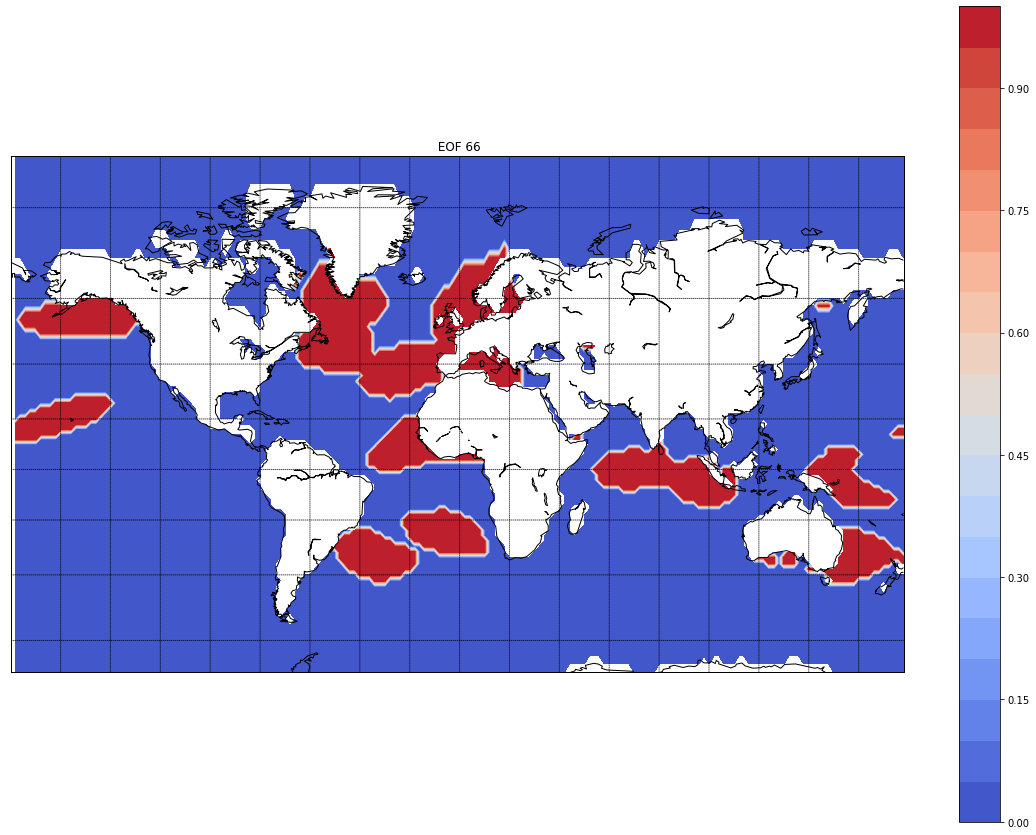

In [65]:
lon  = lon1_sst
lat = lat_sst
m=Basemap(projection='mill',lat_ts=10,llcrnrlon=lon1_sst.min(), \
  urcrnrlon=lon1_sst.max(),llcrnrlat=lat_sst.min()+20,urcrnrlat=lat_sst.max(), \
  resolution='c')

lon2, lat2 = np.meshgrid(lon,lat)
x, y = m(lon2, lat2)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='gray',lake_color='gray')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
m.drawmapboundary(fill_color='white')
cs = m.contourf(x,y,deg_result,20,cmap=plt.cm.get_cmap('coolwarm'))
plt.title(' EOF {}'.format(pc))
#cbar.ax.tick_params(labelsize=25)
plt.colorbar();
#plt.savefig("EOF{}.png".format(pc))
#plt.savefig("EOFs PCMCI.png")

In [47]:
level = 52
if np.abs(np.nanmin(deg)) > np.abs(np.nanmax(deg)):
    limit = np.nanpercentile(deg, 1 - level)
    deg[deg>=limit]=0
else:
    limit = np.nanpercentile(deg, level)
    deg[deg<=limit]=0

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys


In [64]:
deg_result[deg_result > 0 ] = 1

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [71]:
set(comps)

{3, 13, 46, 50, 51, 60, 65, 66, 71, 72, 82, 85, 90, 91}

In [11]:
level = 99

In [12]:
df_sst["pc"] = Vr[:,0]


if np.abs(np.nanmin(deg)) > np.abs(np.nanmax(deg)):
    limit = np.nanpercentile(deg, 1 - level)
    deg[deg>=limit]=0
    deg[deg<limit]=1
else:
    limit = np.nanpercentile(deg, level)
    deg[deg<=limit]=0
    deg[deg>limit]=1

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less_equal
  # Remove the CWD from sys.path while we load stuff.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


In [6]:
pc = 1

In [8]:
df_sst["pc"] = V[:,pc-1]

#lon1 = np.arange(-178.75,179.0,2.5)
lon1_sst = np.arange(-180,180,2)
#lat1 = np.arange(-40,40,2.5)

deg = np.zeros((len(lat_sst),len(lon1_sst)))

lat_number = deg.shape[0]
lon_number = deg.shape[1]

for i in range(lat_number):
    for j in range(lon_number):
        if not df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values.size == 0:
            deg[i,j] = df_sst[(df_sst.lats == lat_sst[i]) & (df_sst.lons == lon1_sst[j])].pc.values
        else:
            deg[i,j]=np.nan


#plt.figure(figsize=(30,15))

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until


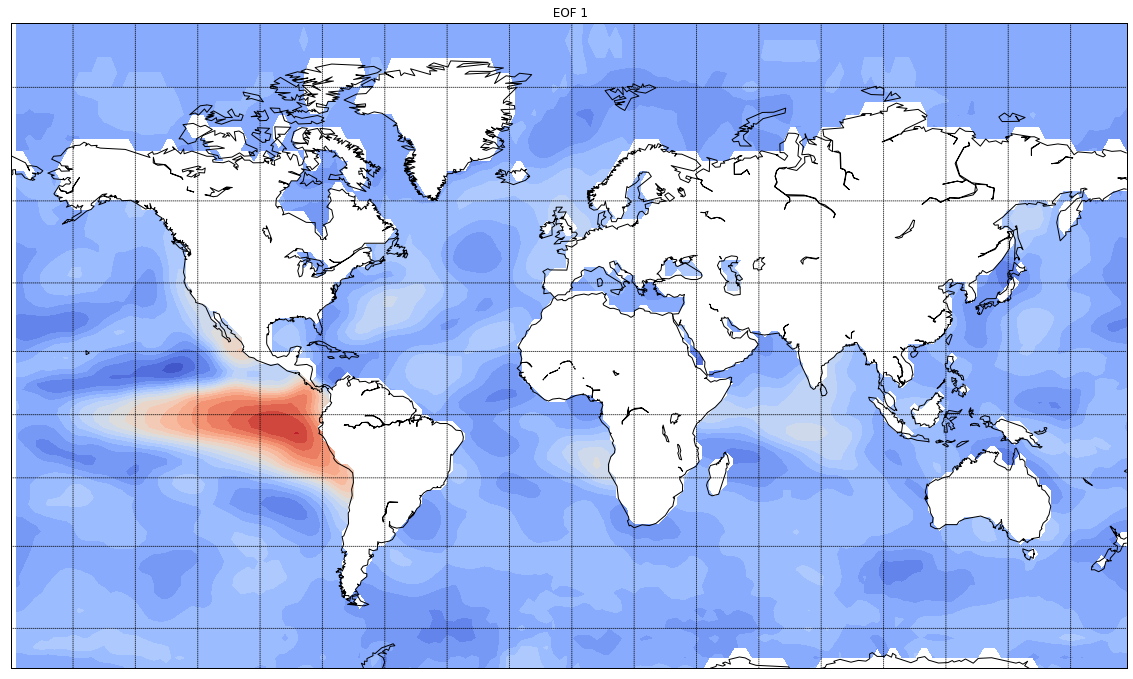

In [11]:
lon  = lon1_sst
lat = lat_sst
m=Basemap(projection='mill',lat_ts=10,llcrnrlon=lon1_sst.min(), \
  urcrnrlon=lon1_sst.max(),llcrnrlat=lat_sst.min()+20,urcrnrlat=lat_sst.max(), \
  resolution='c')

lon2, lat2 = np.meshgrid(lon,lat)
x, y = m(lon2, lat2)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='gray',lake_color='gray')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
m.drawmapboundary(fill_color='white')
cs = m.contourf(x,y,deg,20,cmap=plt.cm.get_cmap('coolwarm'))
plt.title(' EOF {}'.format(pc))
#cbar.ax.tick_params(labelsize=25)
#plt.colorbar();
plt.savefig("EOF{}.png".format(pc))

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until


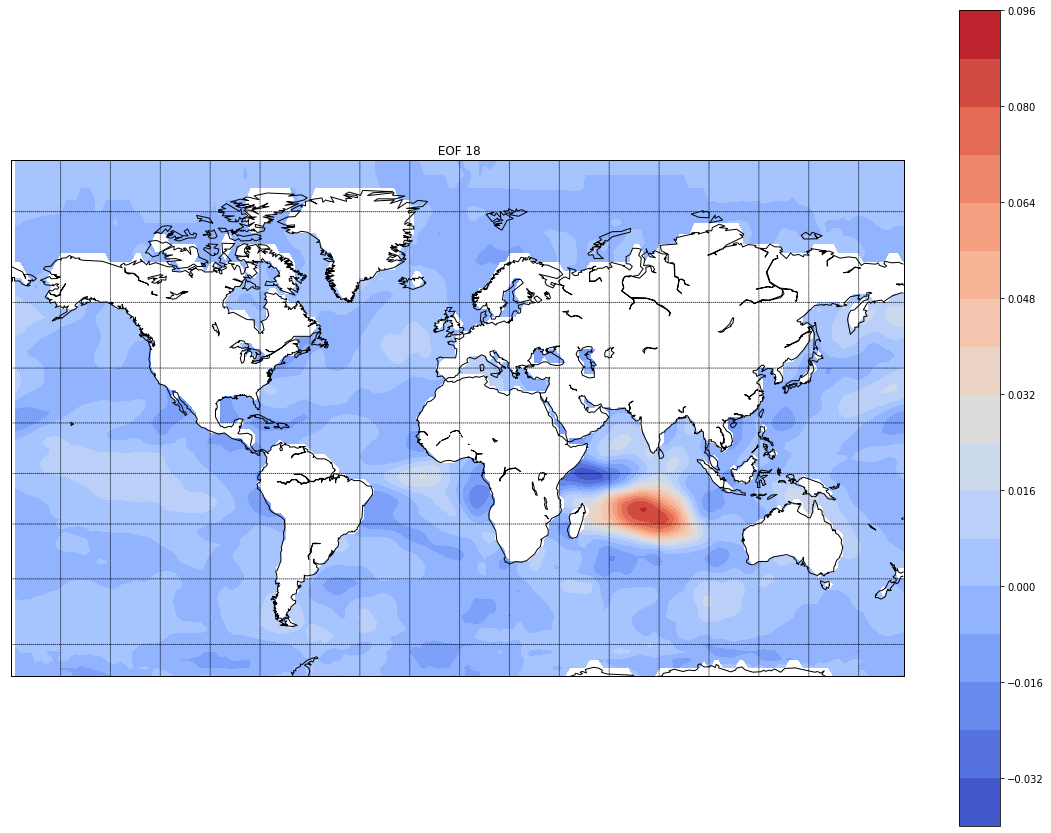

In [20]:
lon  = lon1_sst
lat = lat_sst
m=Basemap(projection='mill',lat_ts=10,llcrnrlon=lon1_sst.min(), \
  urcrnrlon=lon1_sst.max(),llcrnrlat=lat_sst.min()+20,urcrnrlat=lat_sst.max(), \
  resolution='c')

lon2, lat2 = np.meshgrid(lon,lat)
x, y = m(lon2, lat2)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(20,15))
#m.fillcontinents(color='gray',lake_color='gray')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
m.drawmapboundary(fill_color='white')
cs = m.contourf(x,y,deg,20,cmap=plt.cm.get_cmap('coolwarm'))
plt.title(' EOF {}'.format(pc))
#cbar.ax.tick_params(labelsize=25)
plt.colorbar();
#plt.savefig("EOF{}.png".format(pc))

In [77]:
#from mpl_toolkits.basemap import shiftgrid

In [145]:
 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

('Accent',
 'Accent_r',
 'Blues',
 'Blues_r',
 'BrBG',
 'BrBG_r',
 'BuGn',
 'BuGn_r',
 'BuPu',
 'BuPu_r',
 'CMRmap',
 'CMRmap_r',
 'Dark2',
 'Dark2_r',
 'GnBu',
 'GnBu_r',
 'Greens',
 'Greens_r',
 'Greys',
 'Greys_r',
 'OrRd',
 'OrRd_r',
 'Oranges',
 'Oranges_r',
 'PRGn',
 'PRGn_r',
 'Paired',
 'Paired_r',
 'Pastel1',
 'Pastel1_r',
 'Pastel2',
 'Pastel2_r',
 'PiYG',
 'PiYG_r',
 'PuBu',
 'PuBuGn',
 'PuBuGn_r',
 'PuBu_r',
 'PuOr',
 'PuOr_r',
 'PuRd',
 'PuRd_r',
 'Purples',
 'Purples_r',
 'RdBu',
 'RdBu_r',
 'RdGy',
 'RdGy_r',
 'RdPu',
 'RdPu_r',
 'RdYlBu',
 'RdYlBu_r',
 'RdYlGn',
 'RdYlGn_r',
 'Reds',
 'Reds_r',
 'Set1',
 'Set1_r',
 'Set2',
 'Set2_r',
 'Set3',
 'Set3_r',
 'Spectral',
 'Spectral_r',
 'Wistia',
 'Wistia_r',
 'YlGn',
 'YlGnBu',
 'YlGnBu_r',
 'YlGn_r',
 'YlOrBr',
 'YlOrBr_r',
 'YlOrRd',
 'YlOrRd_r',
 'afmhot',
 'afmhot_r',
 'autumn',
 'autumn_r',
 'binary',
 'binary_r',
 'bone',
 'bone_r',
 'brg',
 'brg_r',
 'bwr',
 'bwr_r',
 'cividis',
 'cividis_r',
 'cool',
 'cool_r',
 'co

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until


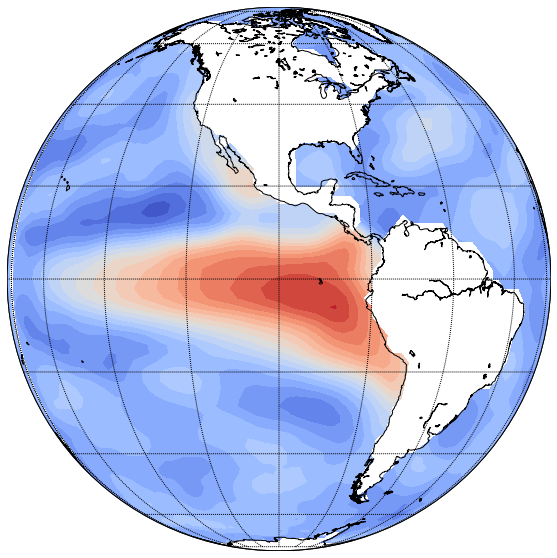

In [10]:
lon  = lon1_sst
lat = lat_sst
m = Basemap(projection='ortho',lat_0=0,lon_0=-100,resolution='l')
lon2, lat2 = np.meshgrid(lon,lat)
x, y = m(lon2, lat2)
x, y = m(lon2, lat2)
fig = plt.figure(figsize=(15,10))
#m.fillcontinents(color='gray',lake_color='gray')
m.drawcoastlines()
m.drawparallels(np.arange(-80.,81.,20.))
m.drawmeridians(np.arange(-180.,181.,20.))
m.drawmapboundary(fill_color='white')
cs = m.contourf(x,y,deg,20,cmap=plt.cm.get_cmap('coolwarm'))
#plt.title(' EOF 1')
#cbar.ax.tick_params(labelsize=25)
#cbar.ax.tick_params(labelsize=30) 
#plt.colorbar()
#cbar = plt.colorbar(cs, orientation='vertical')
#cbar.ax.tick_params(labelsize=18)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


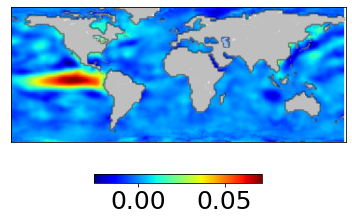

In [10]:

map = Basemap(llcrnrlon=-180, llcrnrlat=-65,urcrnrlon=180,urcrnrlat=80)
#map = Basemap(projection='nplaea', boundinglat=40, lon_0=270)
map.fillcontinents(color='grey', alpha=0.5)
map.drawcoastlines(linewidth=0.)


xx, yy = meshgrid(lon1_sst, lat_sst)
cs = map.pcolormesh(xx, yy, deg, shading= 'gouraud',cmap=plt.cm.jet)
cbar = plt.colorbar(cs, orientation='horizontal', shrink=0.5)
cbar.ax.tick_params(labelsize=25)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


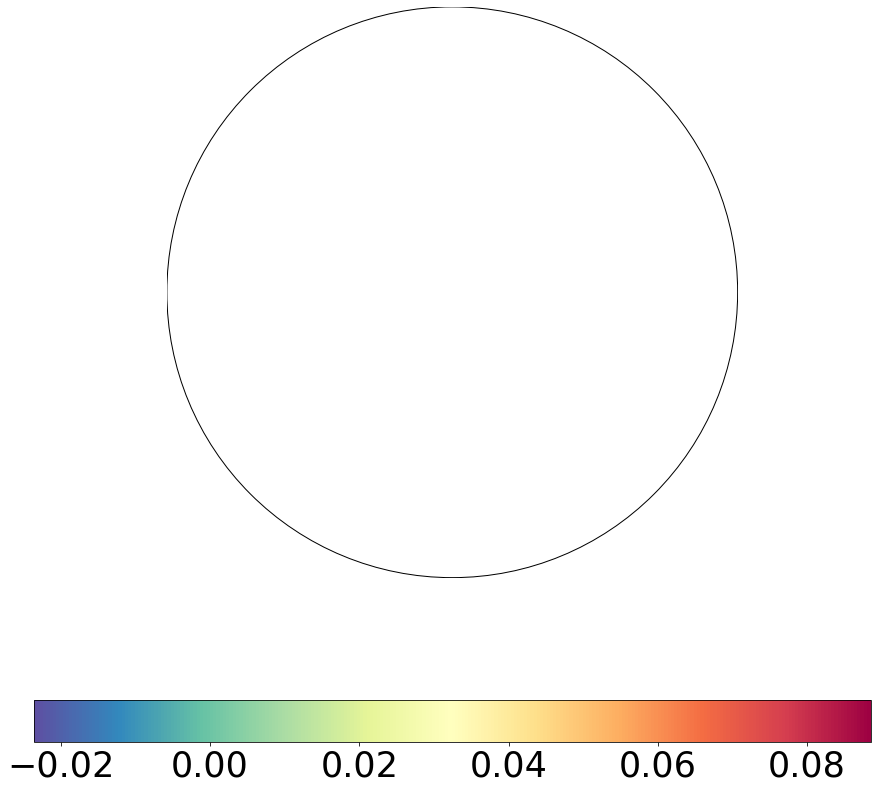

In [12]:
EOF_plot(1, df_sst, Vr, lat_sst, lon_sst)

/home/mathsys2/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


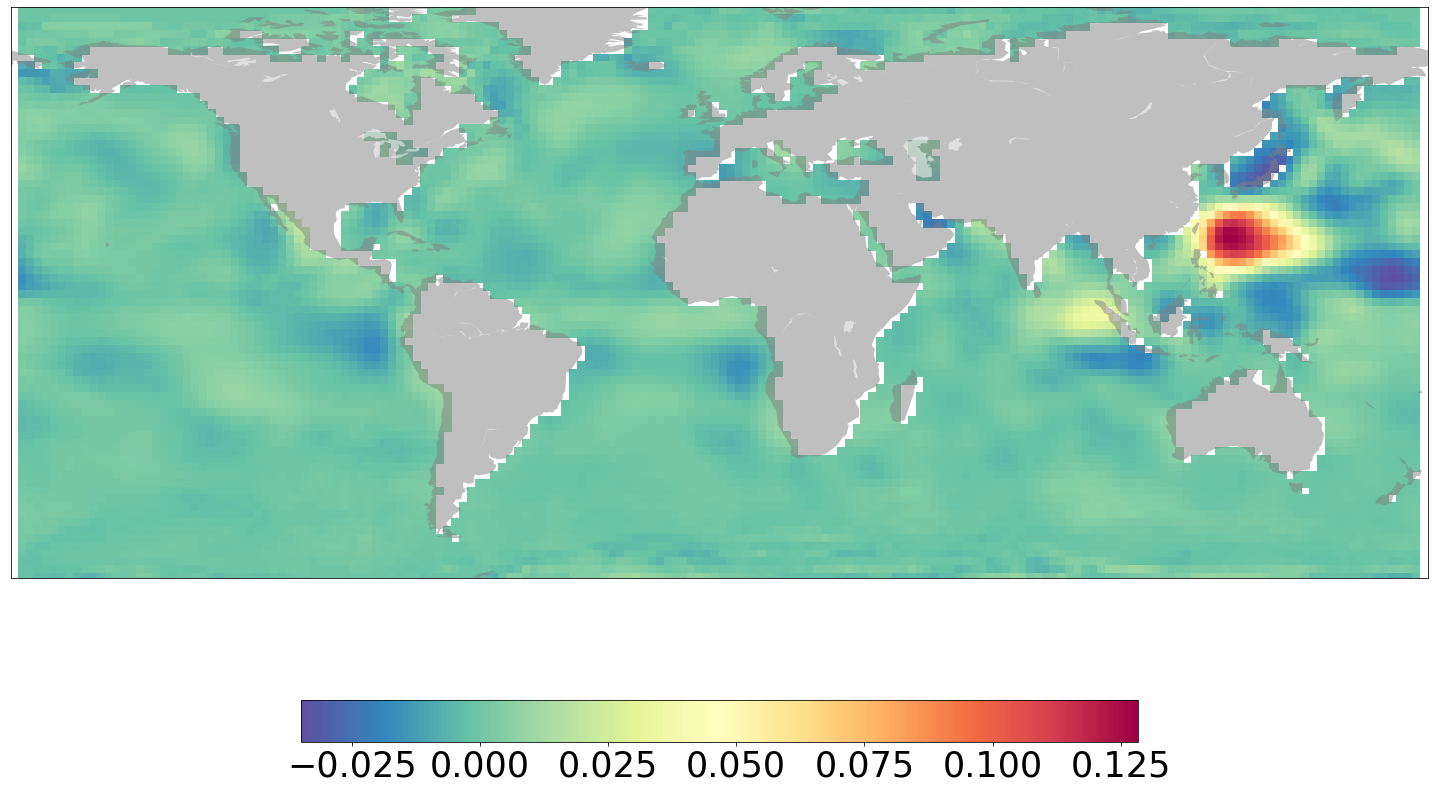

In [43]:
EOF_plot(47, df_sst, Vr, lat_sst, lon_sst)